In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import EuroSAT
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets import EuroSAT
from src.EuroSat_dataloaders import transformation_eurosat
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
import tqdm
import torchmetrics.classification

from src.EuroSat_dataloaders import transformation_eurosat
from torchvision.datasets import EuroSAT
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader

from src.EuroSat_dataloaders import Train_Dataset_EuroSat,Test_Dataset_EuroSat
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
from src.faithfulness.perturbation import eurosat_perturbation, thr_fc, thr_fc_bin
from src.faithfulness.silency_map import Silency_map_gen
from src.faithfulness.metrics import *

In [19]:
# model load:
resnet50 = torch.load("finished\\ResNet50\\resnet50_model.pth")
resnet50.cuda()
# dataset:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(224,antialias=None),
])
ds = EuroSAT("../EuroSat",transform=transforms,target_transform=transformation_eurosat,download=False)
ds_test = Test_Dataset_EuroSat(ds)

# target layer:
cam_type = "grad_cam"
target_layers = [resnet50.layer4[-1]]

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [26]:
class FaithfulnessMeasurment:
    def __init__(self,model, target_layers, ds, cam_type = "grad_cam"):
        self.model = model
        self.ds = ds
        self.cam_type = cam_type
        self.sil_gen = Silency_map_gen(model, ds, target_layers)

    def get_NSS_scores(self, perturbation_fc=eurosat_perturbation, tr_fc = thr_fc, tr_fc_b = thr_fc_bin):
        sum_ = 0.0
        score_lst = []
        for i,tq in zip(range(len(ds_test)-5380),tqdm.tqdm(range(len(ds_test)))):
            sl , pert_sl = self.sil_gen.get_pair_sailency(i,tr_fc=tr_fc,cam_type=self.cam_type,perturbation_func=perturbation_fc)
            score_ = NSS_func(sl , pert_sl, tr_fc = tr_fc_b)
            score_lst.append(score_)
            sum_ += score_
        return sum_/len(ds_test),score_lst

    def get_IG_scores(self, perturbation_fc=eurosat_perturbation, e=1, tr_fc = thr_fc, tr_fc_b = thr_fc_bin):
        sum_ = 0.0
        baseline_im = torch.zeros(self.sil_gen.ds[0][0].shape)
        baseline_sl = self.sil_gen.get_silency_map_input(baseline_im)
        score_lst = []
        for i,tq in zip(range(len(ds_test)-5380),tqdm.tqdm(range(len(ds_test)))):
            sl , pert_sl = self.sil_gen.get_pair_sailency(i,tr_fc=tr_fc,cam_type=self.cam_type,perturbation_func=perturbation_fc)
            score_ = IG_func(sl , pert_sl, baseline_sl, e=e, tr_fc = tr_fc_b)
            score_lst.append(score_)
            sum_ += score_
        return sum_/len(ds_test),score_lst

    def get_MSE_scores(self, perturbation_fc=eurosat_perturbation, tr_fc = thr_fc, tr_fc_b = thr_fc_bin):
        sum_ = 0.0
        score_lst = []
        for i,tq in zip(range(len(ds_test)-5380),tqdm.tqdm(range(len(ds_test)))):
            score_ = MSE_func(self.sil_gen, i, self.model, perturbation_fc)
            score_lst.append(score_)
            sum_ += score_
        return sum_/len(ds_test),score_lst

    def get_SIM_scores(self, perturbation_fc=eurosat_perturbation, tr_fc = thr_fc, no_bins = 20):
        sum_ = 0.0
        score_lst = []
        for i,tq in zip(range(len(ds_test)-5380),tqdm.tqdm(range(len(ds_test)))):
            sl , pert_sl = self.sil_gen.get_pair_sailency(i,tr_fc=tr_fc,cam_type=self.cam_type,perturbation_func=perturbation_fc)
            score_ = SIM_func(sl , pert_sl, no_bins=no_bins)
            score_lst.append(score_)
            sum_ += score_
        return sum_/len(ds_test),score_lst

    def get_CC_scores(self, perturbation_fc=eurosat_perturbation, tr_fc = thr_fc, no_bins = 20):
        sum_ = 0.0
        score_lst = []
        for i,tq in zip(range(len(ds_test)-5380),tqdm.tqdm(range(len(ds_test)))):
            sl , pert_sl = self.sil_gen.get_pair_sailency(i,tr_fc=tr_fc,cam_type=self.cam_type,perturbation_func=perturbation_fc)
            score_ = CC_func(sl , pert_sl, no_bins = no_bins)
            score_lst.append(score_)
            sum_ += score_
        return sum_/len(ds_test),score_lst
    


In [27]:
fmeasure = FaithfulnessMeasurment(resnet50, target_layers, ds_test)

In [28]:

fmeasure.get_NSS_scores()
fmeasure.get_IG_scores()
fmeasure.get_MSE_scores()
fmeasure.get_SIM_scores()
fmeasure.get_CC_scores()


  0%|          | 0/5400 [00:00<?, ?it/s]c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  0%|          | 19/5400 [00:01<05:11, 17.29it/s]


(0.000874443915271051,
 [0,
  0,
  0.3660966125824664,
  -0.0817384194154523,
  0.047375339963755946,
  0.777132142824446,
  0.252185259167473,
  0.9156195638392604,
  0.6768357823939888,
  0.3639054154912881,
  0.8408633635890164,
  0.16331872396187164,
  0.6703491588290644,
  0,
  0,
  0.06925737690294204,
  -0.01031089992462416,
  0,
  0,
  -0.32889227774182156])

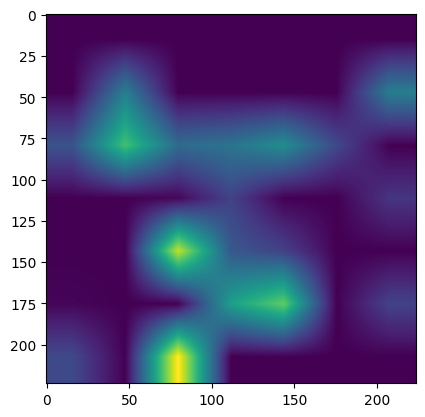

(224, 224)


In [ ]:
sil_gen = Silency_map_gen(resnet50, ds_test, target_layers)

targets = None
mask = sil_gen.get_silency_map(0,targets, cam_type)
plt.imshow(mask)
plt.show()
print(mask.shape)